# Classification of trapped particles
Using forward scattering information.

In [1]:
import numpy as np
import os
from scipy import *
import pandas as pd
from matplotlib.pyplot import *
from sklearn import *

# Functions to load the time domain data, transform it to the FFT space, PCA space, etc...

In [2]:
def load_data(npoints, folder_path = "D:data OT//"):
    """
    Load the data, added targets2 for making a pool for the stratified 
    cross-validation procedure
    """

    path_files_TD = [folder_path+f for f in os.listdir(folder_path) if f.endswith('.dat')]

    #store the info for each file
    target = [] #type of target
    particle_group=[]
    x_data = [] #xdata
    y_data = [] #ydata
    sum_data = [] #intensity data


    for i in range(0,len(path_files_TD)):


        current_path = path_files_TD[i]

        current_df = pd.read_csv(current_path,skiprows=2,header=None,delimiter='\t')
        
        #max n_segments possible
        n_segments = int(len(current_df[0])/npoints)
        
        xx = np.array(current_df[0])[0:nsegments*npoints]
        yy = np.array(current_df[1])[0:nsegments*npoints]
        sums = np.array(current_df[2])[0:nsegments*npoints]

        #alterei isto que me estava a dar problemas com segmentos de tamanho variável
        x_data.append(np.array([xx[int(i*npoints):int((i+1)*npoints)] for i in range(0, n_segments)]))
        y_data.append(np.array([yy[int(i*npoints):int((i+1)*npoints)] for i in range(0, n_segments)]))
        sum_data.append(np.array([sums[int(i*npoints):int((i+1)*npoints)] for i in range(0, n_segments)]))

        print(current_path + " Read "+ str(n_segments) + " segments", end = '\r')

        for i in range(0,int(len(xx)/npoints)):

            target.append(current_path.split('//')[-1].split('.')[0][:-1])
            
            #this will create a new index that corresponds to particle number, to be grouped in the cross-validation strategy
            particle_group.append(current_path.split('//')[-1].split('.')[0][-1:])


    return target, np.array(x_data), np.array(y_data), np.array(sum_data), np.array(particle_group)


def preprocess_data_fft(x_data, y_data, sum_data, target):
    
    """
    Computes the fft for each data, labels, dummy_labels and unique_targets list
    """
    data_X= []
    data_Y = []
    data_Sum = []
    #remove the continuum component
    init = 1
    end = -1
    
    for i in range(0,len(x_data)):
        for j in range(0,len(x_data[i])):
            fft_x = np.fft.fft(x_data[i][j])[init:end]
            fft_y = np.fft.fft(y_data[i][j])[init:end]
            fft_sum = np.fft.fft(sum_data[i][j])[init:end]
            
            #fft_x = np.log10(np.abs(fft_x))
            #fft_y = np.log10(np.abs(fft_y))
            #fft_sum = np.log10(np.abs(fft_sum))
            
            data_X.append(np.abs(fft_x))
            data_Y.append(np.abs(fft_y))
            data_Sum.append(np.abs(fft_sum))
            

    data_X=np.array(data_X)
    data_Y=np.array(data_Y)
    data_Sum=np.array(data_Sum)

    dummy_labels = []
    labels = []
    unique_targets = np.unique(target)
    for i in range(0,len(target)):
        
        labels.append(np.where(target[i]==unique_targets)[0][0])
        
        
        #dummy
        index = np.where(target[i]==unique_targets)[0][0]
        arr = np.zeros(len(unique_targets))
        arr[index] = 1 
        dummy_labels.append(arr)

    labels=np.array(labels)
    dummy_labels = np.array(dummy_labels)
    
    return data_X, data_Y, data_Sum, labels, dummy_labels, unique_targets


        

def pca_data_construct_new_model(data_X, data_Y, data_Sum, ncomp=3 ):
    """
    Train and projects the data in the PCA space, 
    recovers the projection and models
    """
        
    model_X = decomposition.PCA(n_components=ncomp)
    model_X.fit(data_X)
    PCs_X = model_X.transform(data_X)

    model_Y = decomposition.PCA(n_components=ncomp)
    model_Y.fit(data_Y)
    PCs_Y = model_Y.transform(data_Y)

    model_Sum = decomposition.PCA(n_components=ncomp)
    model_Sum.fit(data_Sum)
    PCs_Sum = model_Sum.transform(data_Sum)
    
    PCs = PCs_Sum[:,:]
    
    return PCs, [model_X,model_Y,model_Sum]

def pca_data_compute_from_previous_model(data_X, data_Y, data_Sum, models, ncomp=3):
    """
    Projects the data with previously trained pca models
    """
    model_X = models[0]
    model_Y = models[1]
    model_Sum = models[2]
    
    PCs_X = model_X.transform(data_X)

    PCs_Y = model_Y.transform(data_Y)

    PCs_Sum = model_Sum.transform(data_Sum)

    PCs = PCs_Sum[:,:]
    
    return PCs


# Load the data

In [3]:

folder = "D:data OT - TT//TotalData//"
nsegments = 2000
npoints   =  5000
target, x_data, y_data, sum_data, particle_group = load_data(npoints, folder)


C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [7]:
data_X, data_Y, data_Sum, labels, dummy_labels, unique_targets = preprocess_data_fft(x_data, y_data, sum_data, target)

In [8]:
#Construct the 6-fold stratified crossvalidation set

def crossval_set(data_X, data_Y, data_Sum, target, particle_group, i):
    """
    Contructs stratified crossvalidation folds taking a particle with number i out and considering it as test
    """
    
    unique_particle_group = np.unique(particle_group)
    
    print("Particle group " + str(i))
        
    #select the test group and append to the lists
    index = np.where(np.array(particle_group) == unique_particle_group[i])[0]
        
    test_sets_data_X = data_X[index]
    test_sets_data_Y = data_Y[index]
    test_sets_data_Sum = data_Sum[index]
    test_sets_labels = target[index]
    test_particle_group = particle_group[index]
        
    #select the train group and append to the lists
    index = np.where(np.array(particle_group) != unique_particle_group[i])[0]
        
    train_sets_data_X = data_X[index]
    train_sets_data_Y = data_Y[index]
    train_sets_data_Sum = data_Sum[index]
    train_sets_labels = target[index]
    train_particle_group = particle_group[index]

    return train_sets_data_X, train_sets_data_Y, train_sets_data_Sum, train_sets_labels, train_particle_group, test_sets_data_X, test_sets_data_Y, test_sets_data_Sum, test_sets_labels, test_particle_group

In [9]:
#Test model function
def test_a_model(model, train_sets_data_X, train_sets_data_Y, train_sets_data_Sum, train_sets_labels, 
                 test_sets_data_X, test_sets_data_Y, test_sets_data_Sum, test_sets_labels, 
                 unique_targets,
                 confusion_matrix = False, ncomp = 3):
    
    """
    Test a given model, returning accuracy results and confusion matrix
    """

    #Train the PC model and obtain the PCs_train projection
    PCs_train,pca_model = pca_data_construct_new_model(train_sets_data_X, train_sets_data_Y, train_sets_data_Sum, ncomp=ncomp)
    
    #use the pca_model previously trained to project the test data
    PCs_test = pca_data_compute_from_previous_model(test_sets_data_X, test_sets_data_Y, test_sets_data_Sum, pca_model, ncomp=ncomp)
    

    model.fit(PCs_train,train_sets_labels)
    score_train = model.score(PCs_train, train_sets_labels)
    score_test = model.score(PCs_test, test_sets_labels)

    #Generate a confusion matrix
    labels_pred = model.predict(PCs_train)
    conf_mat_train = metrics.confusion_matrix(train_sets_labels, labels_pred,normalize="true")
    
    #Generate a confusion matrix
    labels_pred = model.predict(PCs_test)
    conf_mat_pred = metrics.confusion_matrix(test_sets_labels, labels_pred,normalize="true")
        
    if confusion_matrix:
        metrics.ConfusionMatrixDisplay(conf_mat_train,display_labels=unique_targets).plot(cmap=cm.Blues)
        yticks(fontsize=6)
        xticks(fontsize=6)
        
        metrics.ConfusionMatrixDisplay(conf_mat_pred,display_labels=unique_targets).plot(cmap=cm.Blues)
        yticks(fontsize=6)
        xticks(fontsize=6)
        

        
        
        
    print("Model Accuracy -> " + str(np.mean(score_test)))
    return score_train, score_test,conf_mat_train,conf_mat_pred

In [12]:
from tqdm import *


model_list_score_train=[]
model_list_score_test=[]
model_list_conf_train=[]
model_list_conf_test=[]

models_to_test=[ensemble.RandomForestClassifier(n_estimators=100,random_state=0), 
                neighbors.KNeighborsClassifier(30),
                svm.SVC(kernel="linear", C=0.25),
               linear_model.LogisticRegression(),
                neural_network.MLPClassifier(activation = 'tanh')]

pbar = tqdm(total=len(models_to_test)*len(np.unique(particle_group)))

for model in models_to_test:

    list_score_train =[]
    list_score_test = []
    list_conf_train = []
    list_conf_test = []
    print(model)
    
    
    for index in range(0,len(np.unique(particle_group))):
        pbar.update(1)
        
        train_sets_data_X, train_sets_data_Y, train_sets_data_Sum, train_sets_labels, train_particle_group, test_sets_data_X, test_sets_data_Y, test_sets_data_Sum, test_sets_labels, test_particle_group = crossval_set(data_X, data_Y, data_Sum, labels, particle_group,index)

        print(np.unique(train_particle_group), end= '\t')
        print(np.unique(test_particle_group))

        score_train, score_test, conf_train, conf_test = test_a_model(model, train_sets_data_X, train_sets_data_Y, train_sets_data_Sum, train_sets_labels, 
                     test_sets_data_X, test_sets_data_Y, test_sets_data_Sum, test_sets_labels, 
                     unique_targets,
                     confusion_matrix = False, ncomp = 2)

        list_score_train.append(score_train)
        list_score_test.append(score_test)
        list_conf_train.append(conf_train)
        list_conf_test.append(conf_test)
    

    model_list_score_train.append(list_score_train)
    model_list_score_test.append(list_score_test)
    model_list_conf_train.append(np.array(list_conf_train).mean(axis=0))
    model_list_conf_test.append(np.array(list_conf_test).mean(axis=0))
    
    




  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

RandomForestClassifier(random_state=0)
Particle group 0
['2' '3' '4' '5' '6']	['1']





  7%|█████▌                                                                             | 2/30 [00:11<02:40,  5.72s/it]

Model Accuracy -> 0.5297684674751929
Particle group 1
['1' '3' '4' '5' '6']	['2']





 10%|████████▎                                                                          | 3/30 [00:22<03:38,  8.08s/it]

Model Accuracy -> 0.6413945766463752
Particle group 2
['1' '2' '4' '5' '6']	['3']





 13%|███████████                                                                        | 4/30 [00:37<04:31, 10.45s/it]

Model Accuracy -> 0.46799116997792495
Particle group 3
['1' '2' '3' '5' '6']	['4']





 17%|█████████████▊                                                                     | 5/30 [00:50<04:45, 11.44s/it]

Model Accuracy -> 0.453494771601541
Particle group 4
['1' '2' '3' '4' '6']	['5']





 20%|████████████████▌                                                                  | 6/30 [01:01<04:33, 11.39s/it]

Model Accuracy -> 0.5516860143725816
Particle group 5
['1' '2' '3' '4' '5']	['6']





 23%|███████████████████▎                                                               | 7/30 [01:13<04:20, 11.33s/it]

Model Accuracy -> 0.580110497237569
KNeighborsClassifier(n_neighbors=30)
Particle group 0
['2' '3' '4' '5' '6']	['1']





 27%|██████████████████████▏                                                            | 8/30 [01:23<04:03, 11.06s/it]

Model Accuracy -> 0.6069459757442117
Particle group 1
['1' '3' '4' '5' '6']	['2']





 30%|████████████████████████▉                                                          | 9/30 [01:33<03:47, 10.82s/it]

Model Accuracy -> 0.6712783619258439
Particle group 2
['1' '2' '4' '5' '6']	['3']





 33%|███████████████████████████▎                                                      | 10/30 [01:44<03:35, 10.75s/it]

Model Accuracy -> 0.4481236203090508
Particle group 3
['1' '2' '3' '5' '6']	['4']





 37%|██████████████████████████████                                                    | 11/30 [01:55<03:24, 10.74s/it]

Model Accuracy -> 0.4408365437534397
Particle group 4
['1' '2' '3' '4' '6']	['5']





 40%|████████████████████████████████▊                                                 | 12/30 [02:05<03:10, 10.61s/it]

Model Accuracy -> 0.5478164731896075
Particle group 5
['1' '2' '3' '4' '5']	['6']





 43%|███████████████████████████████████▌                                              | 13/30 [02:16<03:02, 10.75s/it]

Model Accuracy -> 0.618232044198895
SVC(C=0.25, kernel='linear')
Particle group 0
['2' '3' '4' '5' '6']	['1']





 47%|██████████████████████████████████████▎                                           | 14/30 [02:33<03:23, 12.74s/it]

Model Accuracy -> 0.535832414553473
Particle group 1
['1' '3' '4' '5' '6']	['2']





 50%|█████████████████████████████████████████                                         | 15/30 [02:47<03:13, 12.93s/it]

Model Accuracy -> 0.6231322634200332
Particle group 2
['1' '2' '4' '5' '6']	['3']





 53%|███████████████████████████████████████████▋                                      | 16/30 [03:00<03:04, 13.14s/it]

Model Accuracy -> 0.6445916114790287
Particle group 3
['1' '2' '3' '5' '6']	['4']





 57%|██████████████████████████████████████████████▍                                   | 17/30 [03:13<02:50, 13.09s/it]

Model Accuracy -> 0.42102366538249864
Particle group 4
['1' '2' '3' '4' '6']	['5']





 60%|█████████████████████████████████████████████████▏                                | 18/30 [03:27<02:37, 13.15s/it]

Model Accuracy -> 0.5113322277501382
Particle group 5
['1' '2' '3' '4' '5']	['6']





 63%|███████████████████████████████████████████████████▉                              | 19/30 [03:42<02:32, 13.88s/it]

Model Accuracy -> 0.4861878453038674
LogisticRegression()
Particle group 0
['2' '3' '4' '5' '6']	['1']


C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)



 67%|██████████████████████████████████████████████████████▋                           | 20/30 [03:53<02:10, 13.06s/it]

Model Accuracy -> 0.5016538037486218
Particle group 1
['1' '3' '4' '5' '6']	['2']


C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)



 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [04:04<01:51, 12.35s/it]

Model Accuracy -> 0.6607636967349197
Particle group 2
['1' '2' '4' '5' '6']	['3']


C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)



 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [04:12<01:28, 11.08s/it]

Model Accuracy -> 0.6098233995584988
Particle group 3
['1' '2' '3' '5' '6']	['4']


C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)



 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [04:22<01:14, 10.63s/it]

Model Accuracy -> 0.4050632911392405
Particle group 4
['1' '2' '3' '4' '6']	['5']


C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)



 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [04:32<01:02, 10.43s/it]

Model Accuracy -> 0.5555555555555556
Particle group 5
['1' '2' '3' '4' '5']	['6']


C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)



 83%|████████████████████████████████████████████████████████████████████▎             | 25/30 [04:42<00:51, 10.28s/it]

Model Accuracy -> 0.5696132596685083
MLPClassifier(activation='tanh')
Particle group 0
['2' '3' '4' '5' '6']	['1']





 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [05:20<01:14, 18.67s/it]

Model Accuracy -> 0.4658213891951488
Particle group 1
['1' '3' '4' '5' '6']	['2']


C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



 90%|█████████████████████████████████████████████████████████████████████████▊        | 27/30 [05:55<01:10, 23.57s/it]

Model Accuracy -> 0.6137244050913115
Particle group 2
['1' '2' '4' '5' '6']	['3']


C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



 93%|████████████████████████████████████████████████████████████████████████████▌     | 28/30 [06:29<00:53, 26.80s/it]

Model Accuracy -> 0.4155629139072848
Particle group 3
['1' '2' '3' '5' '6']	['4']


C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



 97%|███████████████████████████████████████████████████████████████████████████████▎  | 29/30 [07:02<00:28, 28.56s/it]

Model Accuracy -> 0.4441386901485966
Particle group 4
['1' '2' '3' '4' '6']	['5']


C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [07:35<00:00, 29.91s/it]

Model Accuracy -> 0.5262576008844666
Particle group 5
['1' '2' '3' '4' '5']	['6']
Model Accuracy -> 0.511049723756906


C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


  7%|█████▎                                                                          | 2/30 [08:40<2:01:21, 260.04s/it]


RandomForestClassifier(random_state=0)
Accuracy Train -> 0.9999631960528225	1.0	0.9998895637769188
Accuracy Test -> 0.5374075828851974	0.6413945766463752	0.453494771601541


C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: scipy.mean is deprecated and will be removed in SciPy 2.0.0, use numpy.mean instead
C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: scipy.mean is deprecated and will be removed in SciPy 2.0.0, use numpy.mean instead


<IPython.core.display.Javascript object>


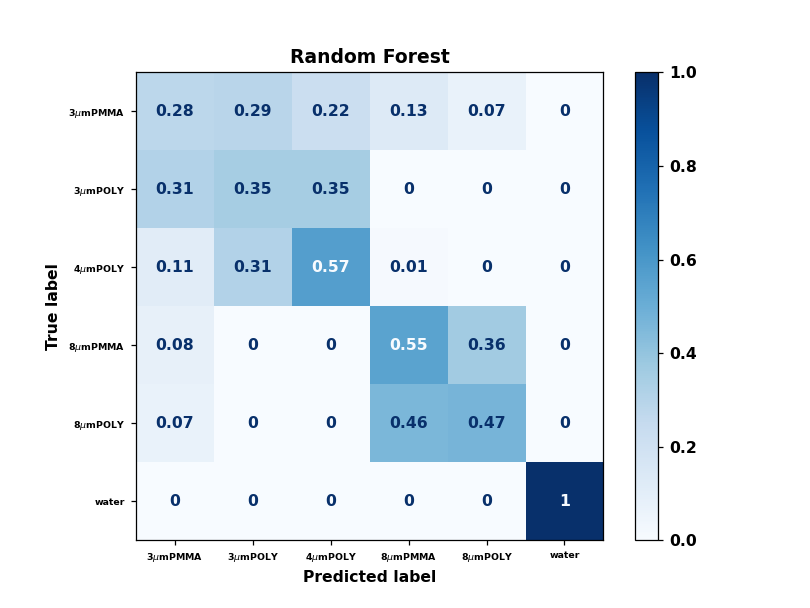

KNeighborsClassifier(n_neighbors=30)
Accuracy Train -> 0.7536692854901137	0.7778391515687141	0.7379927128188142
Accuracy Test -> 0.5555388365201749	0.6712783619258439	0.4408365437534397


<IPython.core.display.Javascript object>


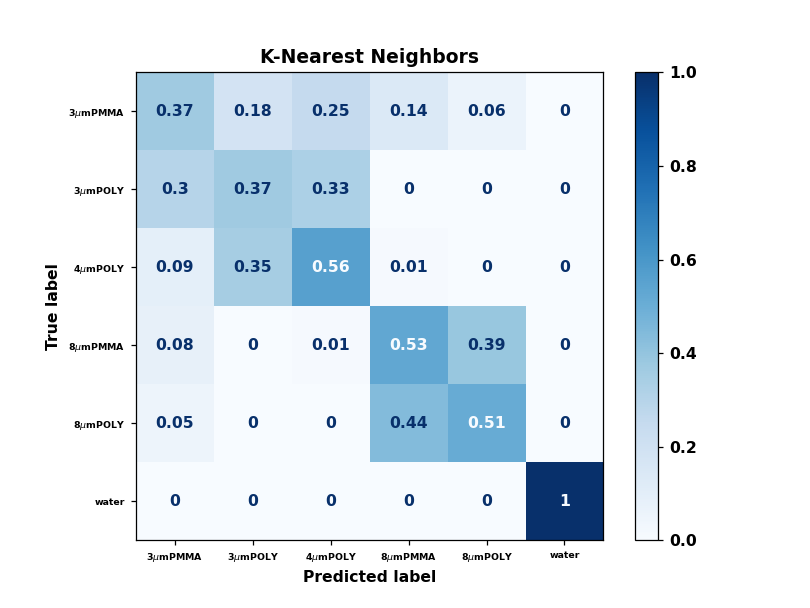

SVC(C=0.25, kernel='linear')
Accuracy Train -> 0.628044978699219	0.6494697304463102	0.5751352544992824
Accuracy Test -> 0.5370166713148399	0.6445916114790287	0.42102366538249864


<IPython.core.display.Javascript object>


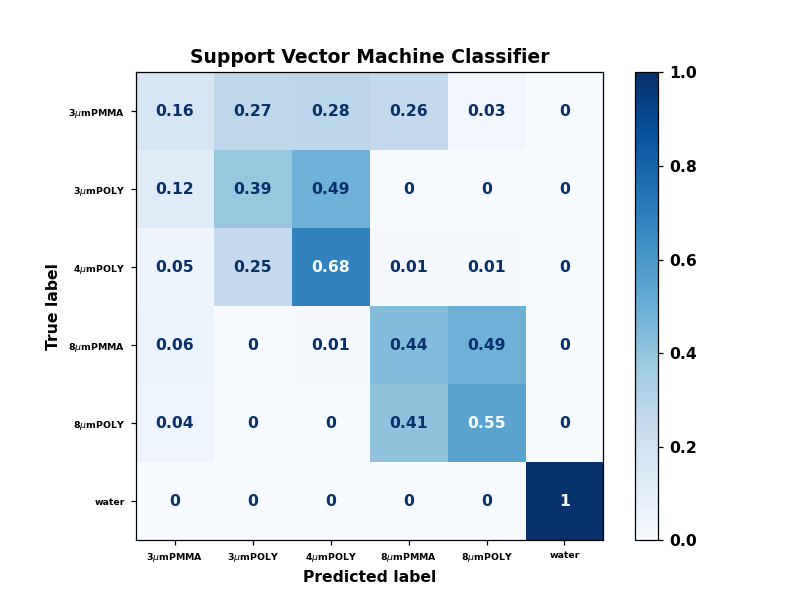

LogisticRegression()
Accuracy Train -> 0.5885369492005295	0.6216305788775961	0.5530528872695153
Accuracy Test -> 0.5504121677342241	0.6607636967349197	0.4050632911392405


<IPython.core.display.Javascript object>


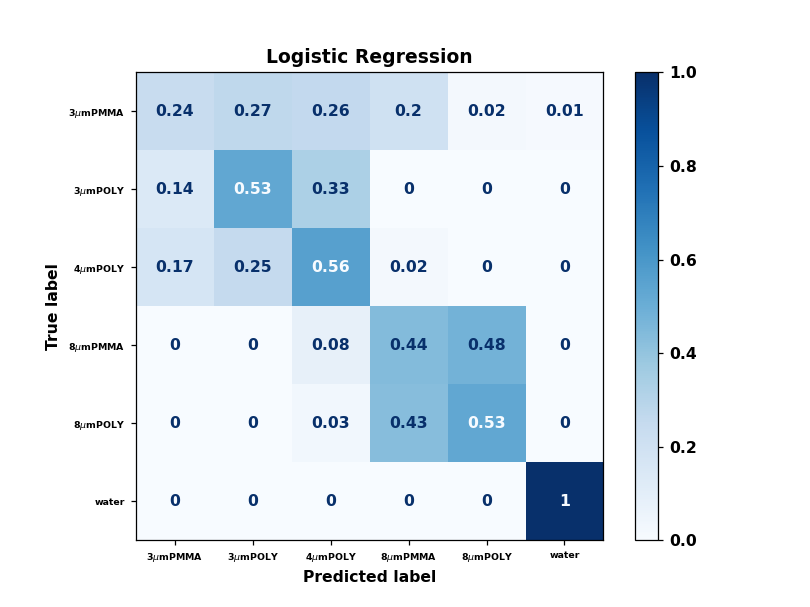

  3%|██▋                                                                             | 1/30 [13:13<6:23:24, 793.27s/it]


MLPClassifier(activation='tanh')
Accuracy Train -> 0.7263989457132524	0.7493371630578878	0.7159567424409623
Accuracy Test -> 0.496092453830619	0.6137244050913115	0.4155629139072848


<IPython.core.display.Javascript object>


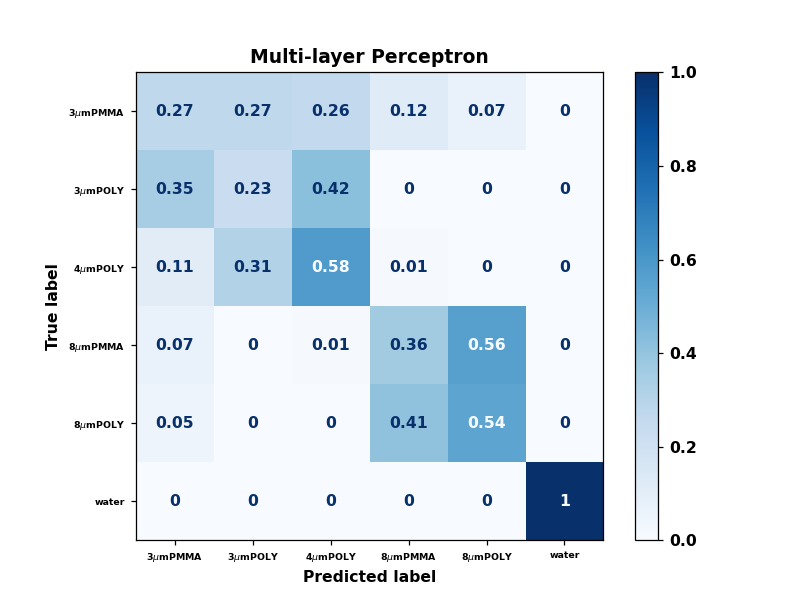

In [13]:
%matplotlib notebook

unique_targets1=[]
for i in range(0,len(unique_targets)):
    unique_targets1.append(r''+unique_targets[i].replace('um','$\mu$m'))

models_labels=['Random Forest', 
                       'K-Nearest Neighbors',
                       'Support Vector Machine Classifier',
                       'Logistic Regression',
                       'Multi-layer Perceptron']
    
    
    
for i in range(0,len(models_to_test)):
    print(models_to_test[i])
    print("Accuracy Train -> "+ str(mean(model_list_score_train[i])), end = '\t')
    print(str(max(model_list_score_train[i])), end = '\t')
    print(str(min(model_list_score_train[i])), end = '\n')
    
    print("Accuracy Test -> "+ str(mean(model_list_score_test[i])), end = '\t')
    print(str(max(model_list_score_test[i])), end = '\t')
    print(str(min(model_list_score_test[i])), end = '\n')
    
    
    conf_mat_pred = model_list_conf_test[i]
    metrics.ConfusionMatrixDisplay(np.round(conf_mat_pred,2),display_labels=unique_targets1).plot(cmap=cm.Blues)
    yticks(fontsize=6)
    xticks(fontsize=6)
    ax=gca()
    ax.set_title(models_labels[i])
    savefig('images//Sum//'+models_labels[i], bbox_inches='tight',dpi=300)
        